<a href="https://colab.research.google.com/github/calebmckay1/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [318]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [319]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

## this thing is really cool

In [0]:
####### Do train/validate/test split with the Tanzania Waterpumps data. #######

In [181]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.75, test_size=0.25, 
                              stratify=train['status_group'], random_state=42)

In [321]:
train.shape, test.shape, val.shape

((44550, 41), (14358, 40), (14850, 41))

In [0]:
####### Begin with baselines for classification. #######

In [322]:
target = 'status_group'
y_train = train[target]
y_train.value_counts(normalize=True)

# 54% of waterpumps are functioning: majority are functioning.

functional                 0.543075
non functional             0.384242
functional needs repair    0.072682
Name: status_group, dtype: float64

In [0]:
####### Select features. Use a scikit-learn pipeline to encode categoricals, #######
####### impute missing values, and fit a decision tree classifier. #######

In [0]:
import numpy as np

def wrangle(X):
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = X.columns
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    X = X.drop(columns='quantity_group')


    return X

In [0]:
train = wrangle(train)

In [0]:
test = wrangle(test)
val = wrangle(val)

In [326]:
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,NaN,2013-02-04,Dmdd,1996.0,DMDD,35.290799,-4.059696,Dinamu Secondary School,NaN,Internal,Magoma,Manyara,21,3.0,Mbulu,Bashay,321.0,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012.0,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,NaN,2013-02-04,Government Of Tanzania,1569.0,DWE,36.656709,-3.309214,Kimnyak,NaN,Pangani,Kimnyak,Arusha,2,2.0,Arusha Rural,Kimnyaki,300.0,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,NaN,2013-02-01,NaN,1567.0,NaN,34.767863,-5.004344,Puma Secondary,NaN,Internal,Msatu,Singida,13,2.0,Singida Rural,Puma,500.0,True,GeoData Consultants Ltd,VWC,P,NaN,2010.0,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,NaN,2013-01-22,Finn Water,267.0,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,NaN,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43.0,Liwale,Mkutano,250.0,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987.0,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260.0,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,NaN,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3.0,Mbinga,Mbinga Urban,60.0,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000.0,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [0]:
target = 'status_group'

train_features = train.drop(columns=[target,'id'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 40].index.tolist()

features = numeric_features + categorical_features

In [0]:
test = test.set_index('id')

In [0]:
x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]

In [330]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True), 
                         SimpleImputer(strategy='median'), StandardScaler(),
                         DecisionTreeClassifier(max_depth=12,random_state=42))

pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'wat...
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=12,
 

In [0]:
####### Get your validation accuracy score. #######

In [331]:
print('Validation Accuracy', pipeline.score(x_val, y_val))
print('Training Accuracy', pipeline.score(x_train, y_train))

Validation Accuracy 0.7568350168350169
Training Accuracy 0.7861279461279461


In [332]:
x_test.shape

(14358, 30)

In [333]:
x_test.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin,region,public_meeting,recorded_by,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,NaN,1996.0,35.290799,-4.059696,NaN,21,3.0,321.0,2012.0,Internal,Manyara,True,GeoData Consultants Ltd,Parastatal,True,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,NaN,1569.0,36.656709,-3.309214,NaN,2,2.0,300.0,2000.0,Pangani,Arusha,True,GeoData Consultants Ltd,VWC,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,NaN,1567.0,34.767863,-5.004344,NaN,13,2.0,500.0,2010.0,Internal,Singida,True,GeoData Consultants Ltd,VWC,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,NaN,267.0,38.058046,-9.418672,NaN,80,43.0,250.0,1987.0,Ruvuma / Southern Coast,Lindi,NaN,GeoData Consultants Ltd,VWC,True,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
49871,500.0,1260.0,35.006123,-10.950412,NaN,10,3.0,60.0,2000.0,Ruvuma / Southern Coast,Ruvuma,NaN,GeoData Consultants Ltd,Water Board,True,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [334]:
x_test['status_group'] = pipeline.predict(x_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
x_test = x_test.reset_index()

In [336]:
x_test.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin,region,public_meeting,recorded_by,scheme_management,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,50785,NaN,1996.0,35.290799,-4.059696,NaN,21,3.0,321.0,2012.0,Internal,Manyara,True,GeoData Consultants Ltd,Parastatal,True,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,functional
1,51630,NaN,1569.0,36.656709,-3.309214,NaN,2,2.0,300.0,2000.0,Pangani,Arusha,True,GeoData Consultants Ltd,VWC,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2,17168,NaN,1567.0,34.767863,-5.004344,NaN,13,2.0,500.0,2010.0,Internal,Singida,True,GeoData Consultants Ltd,VWC,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,functional
3,45559,NaN,267.0,38.058046,-9.418672,NaN,80,43.0,250.0,1987.0,Ruvuma / Southern Coast,Lindi,NaN,GeoData Consultants Ltd,VWC,True,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,non functional
4,49871,500.0,1260.0,35.006123,-10.950412,NaN,10,3.0,60.0,2000.0,Ruvuma / Southern Coast,Ruvuma,NaN,GeoData Consultants Ltd,Water Board,True,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional


In [0]:
test_final = x_test[['id', 'status_group']].copy()

In [338]:
test_final.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
test_final.to_csv('prediction.csv',index=False)

In [0]:
# from google.colab import files
# files.download('prediction.csv')

In [0]:
####### Get and plot your feature importances. #######

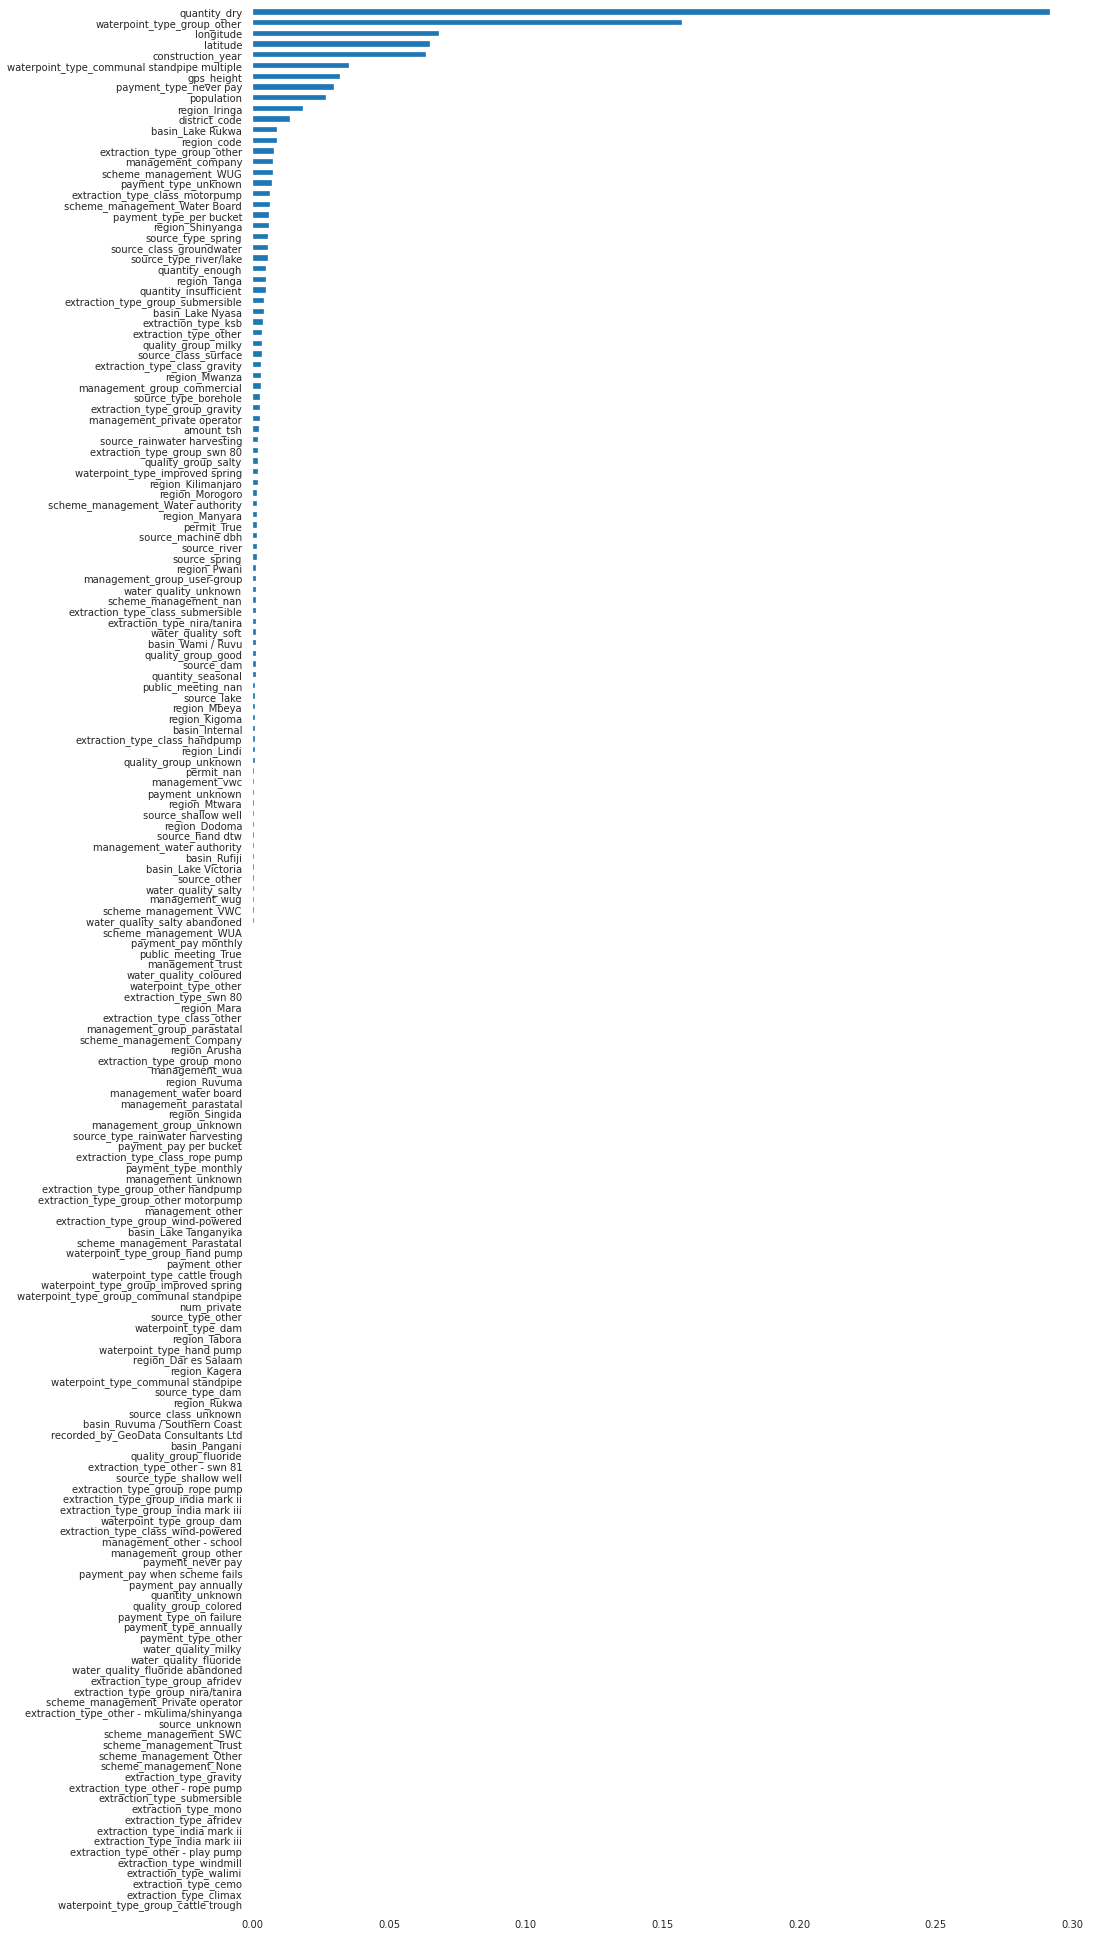

In [341]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(x_val).columns
important = pd.Series(model.feature_importances_, encoded_columns)

plt.figure(figsize=(15,35))
important.sort_values().plot.barh()

In [0]:
####### Submit your predictions to our Kaggle competition. #######

In [0]:
####### Commit your notebook to your fork of the GitHub repo. #######